# Análisis Exploratorio de datos 

## Importación de librerias y creación de funciones

In [22]:
# Importar las bibliotecas necesarias
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch
import seaborn as sns
from yellowbrick.cluster import silhouette_visualizer

In [23]:
def cargar_csv(ruta_csv):
    try:
        df = pd.read_csv(ruta_csv)
        return df
    except FileNotFoundError:
        print(f"El archivo en la ruta {ruta_csv} no se encontró.")
    except pd.errors.EmptyDataError:
        print("El archivo CSV está vacío.")
    except pd.errors.ParserError:
        print("Error al analizar el archivo CSV.")
    except Exception as e:
        print(f"Ocurrió un error: {e}")

In [24]:
def graficar_histograma(df, y, x, ax):
    sns.histplot(data=df[df[y] == 1], x=x, bins=20, kde=True, color='green', label='1', ax=ax)
    sns.histplot(data=df[df[y] == 0], x=x, bins=20, kde=True, color='red', label='0', ax=ax)
    
    ax.set_xlabel(f'{x}')
    ax.set_ylabel('Frecuencia')
    ax.set_title(f'Histograma de Frecuencia - Precipitación de lluvia acumulada en {x}')
    ax.legend()

In [25]:
def crear_tabla_contingencia(df, columna1, columna2):

    tabla_contingencia = pd.crosstab(df[columna1], df[columna2]).reset_index(drop=False)
    tabla_contingencia.index.name = None
    tabla_contingencia.columns.name = None
    tabla_contingencia=tabla_contingencia.sort_values(by=0,ascending=False)
    return tabla_contingencia

In [26]:
df=cargar_csv(os.path.join('..','Data','output','train_data_1.csv'))

In [27]:
df.head()

,ELEVACION,PENDIENT,zonificacion,Nomenclatura_del_Suelo,tipo_geologia,24h,7d,10d,15d,30d,60d,90d,deslizamientos
0,1030.110840,21.268663,Riesgo medio,Zonas urbanas continuas,Formacion Volcanica,14.0,197.0,210.0,366.0,583.0,746.0,908.0,1
1,1176.433594,56.848099,Riesgo alto,Zonas urbanas continuas,Formacion Guachinte,7.6,83.5,110.0,213.5,343.7,452.1,531.0,1
2,1038.540527,32.060978,Riesgo bajo,Zonas urbanas continuas,Formacion Guachinte,9.5,91.2,117.0,215.4,266.2,331.3,434.0,1
3,1657.118408,47.167477,Amenaza baja,Bosque mixto abierto alto de tierra firme,Formacion Volcanica,0.0,26.0,42.0,53.0,93.0,198.0,293.0,1
4,980.576721,20.477095,Riesgo bajo,Zonas urbanas continuas,Formacion Guachinte,11.0,11.2,12.3,39.4,43.9,175.5,323.0,0


## Variables Numéricas

Primeramente, es común en problema de clasificación revisar si se trata de un problema de clases desbalanceadas o no. El desbalanceo de clases ocurre cuando hay muchas más muestras de una clase que de otra. Por ejemplo en este caso, si nos interesa detectar deslizamientos de tierra y la mayoría de los registros reportan un no deslizamiento, puede ser difícil para un modelo de aprendizaje automático identificar los deslizamientos ya que tiene menos ejemplos para aprender de estas instancias. Por ende, es importante revisar esto al explorar los datos, para asegurarse de que el modelo pueda hacer predicciones precisas y útiles. Sin abordar este desbalanceo, el modelo podría no estimar nuevos datos correctamente. 


Para esto haremos una revisión simple de cuantos registros hay para cada clase en la variable objetivo

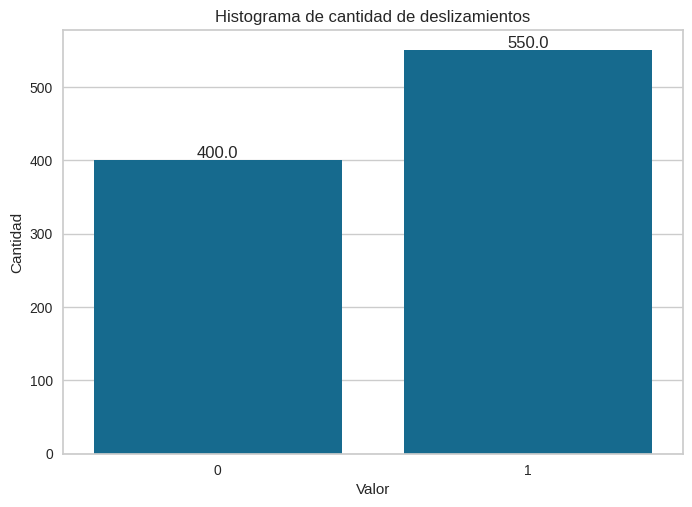

In [28]:
# Grafica el histograma usando Seaborn.
ax=sns.countplot(data=df, x='deslizamientos')

# Añade etiquetas y título
plt.xlabel('Valor')
plt.ylabel('Cantidad')
plt.title('Histograma de cantidad de deslizamientos')
# Agrega los valores en las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

Donde 0 representa la clase negativa que es "No Deslizamiento de tierra" en punto geográfico 
y 1 representa la clase positiva que es "Deslizamiento de tierra" 

Esta es la lógica que seguiremos en las implementaciones. 

Como podemos ver, no se presenta un problema grande de desbalance, ya que hay una relación de aproximadamente 40/60 de cada tipo de clase, por lo general se establece que hay desbalance de clases cuando hay una relación 10/90. Pero vemos que este no es el caso 

Ahora vemos cómo se comportan las variables de precipitación de lluvia respecto la variable objetivo 

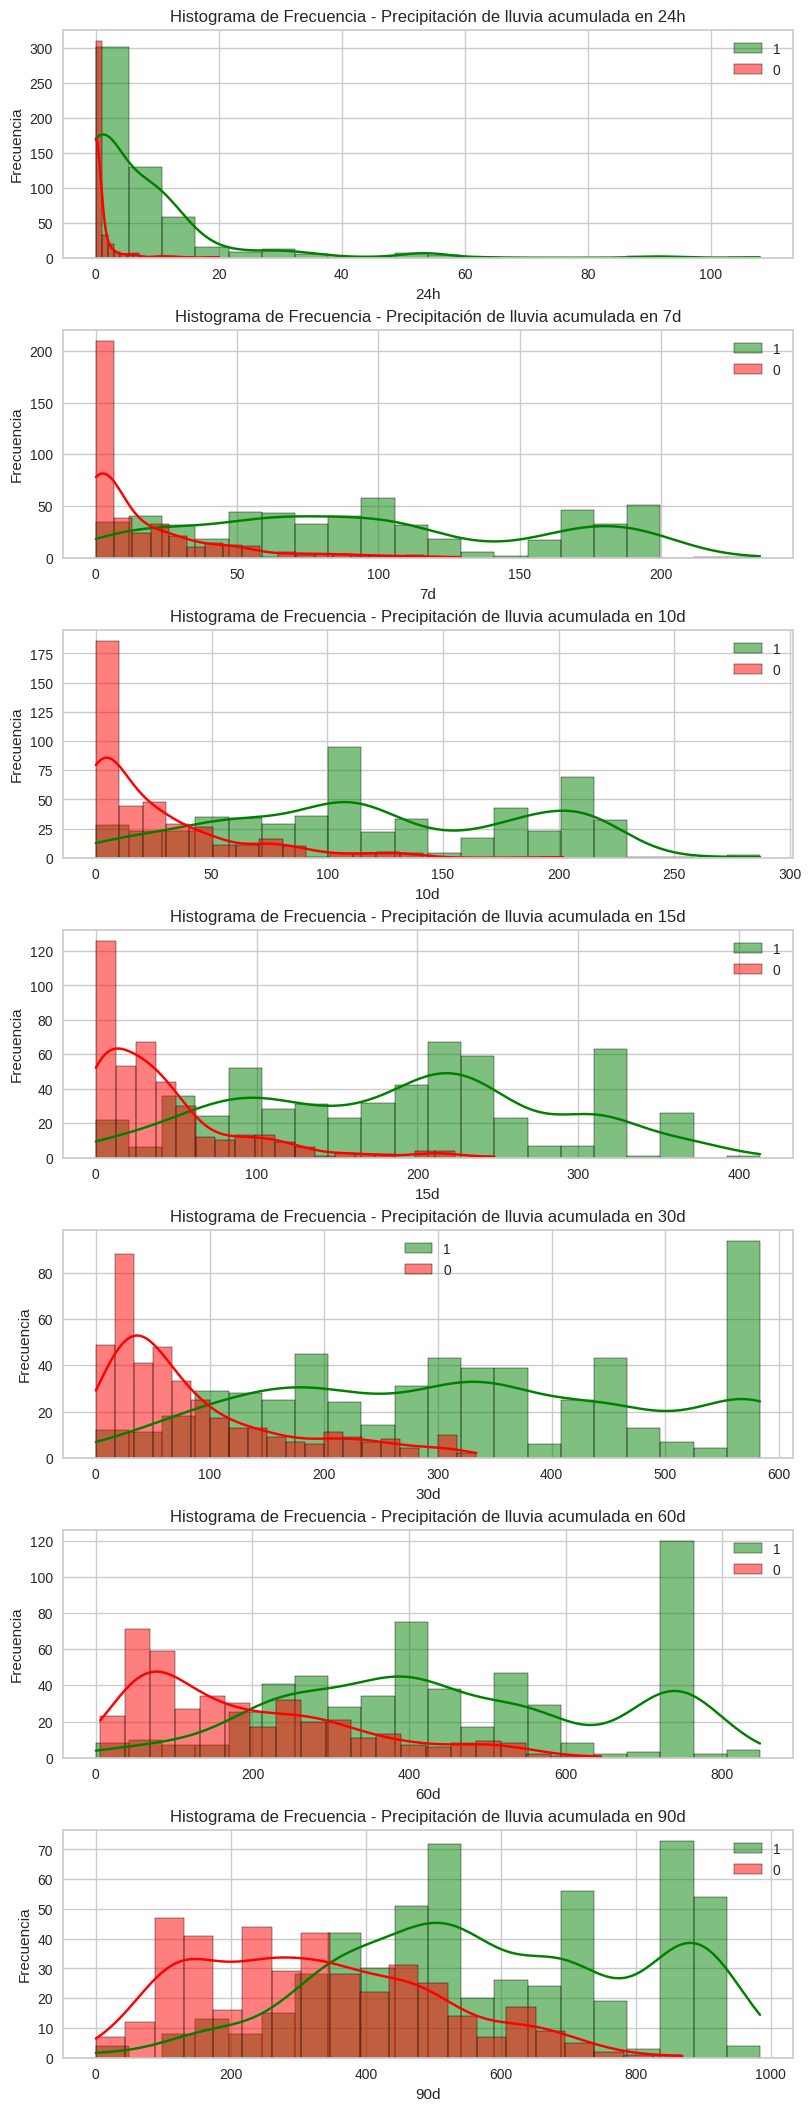

In [29]:
columnas_a_graficar = ['24h', '7d', '10d','15d','30d','60d','90d'] 
n = len(columnas_a_graficar)
fig, axes = plt.subplots(n, 1, figsize=(8, 3 * n), constrained_layout=True)
if n == 1:
    axes = [axes]
for columna, ax in zip(columnas_a_graficar, axes):
    graficar_histograma(df, y='deslizamientos', x=columna, ax=ax)
plt.show()

En este caso vemos que para puntos donde ha habido deslizamientos de tierra, existe mayor cantidad de lluvia acumulada en mm en comparación con los que no han presentado deslizamientos. Esto nos sugiere que las variables de precipitación son importantes en la tendencia de la variable objetivo (deslizamientos o no)

También podremos pensar que al tratarse de variables que capturan data de manera acumulada, el valor o aporte que brinda una variable, tambien lo puede brindar en el mismo grado cualquier otra, pudiendo llegar a redundancias y posteriormente si se quiere evaluar modelos a "over-fitting". Podemos revisar las correlaciones entre las variables de precipitaciones

Realizaremos un boxplot para comparar la distribución de las variables de precipitación para cada valor de la variable objetivo

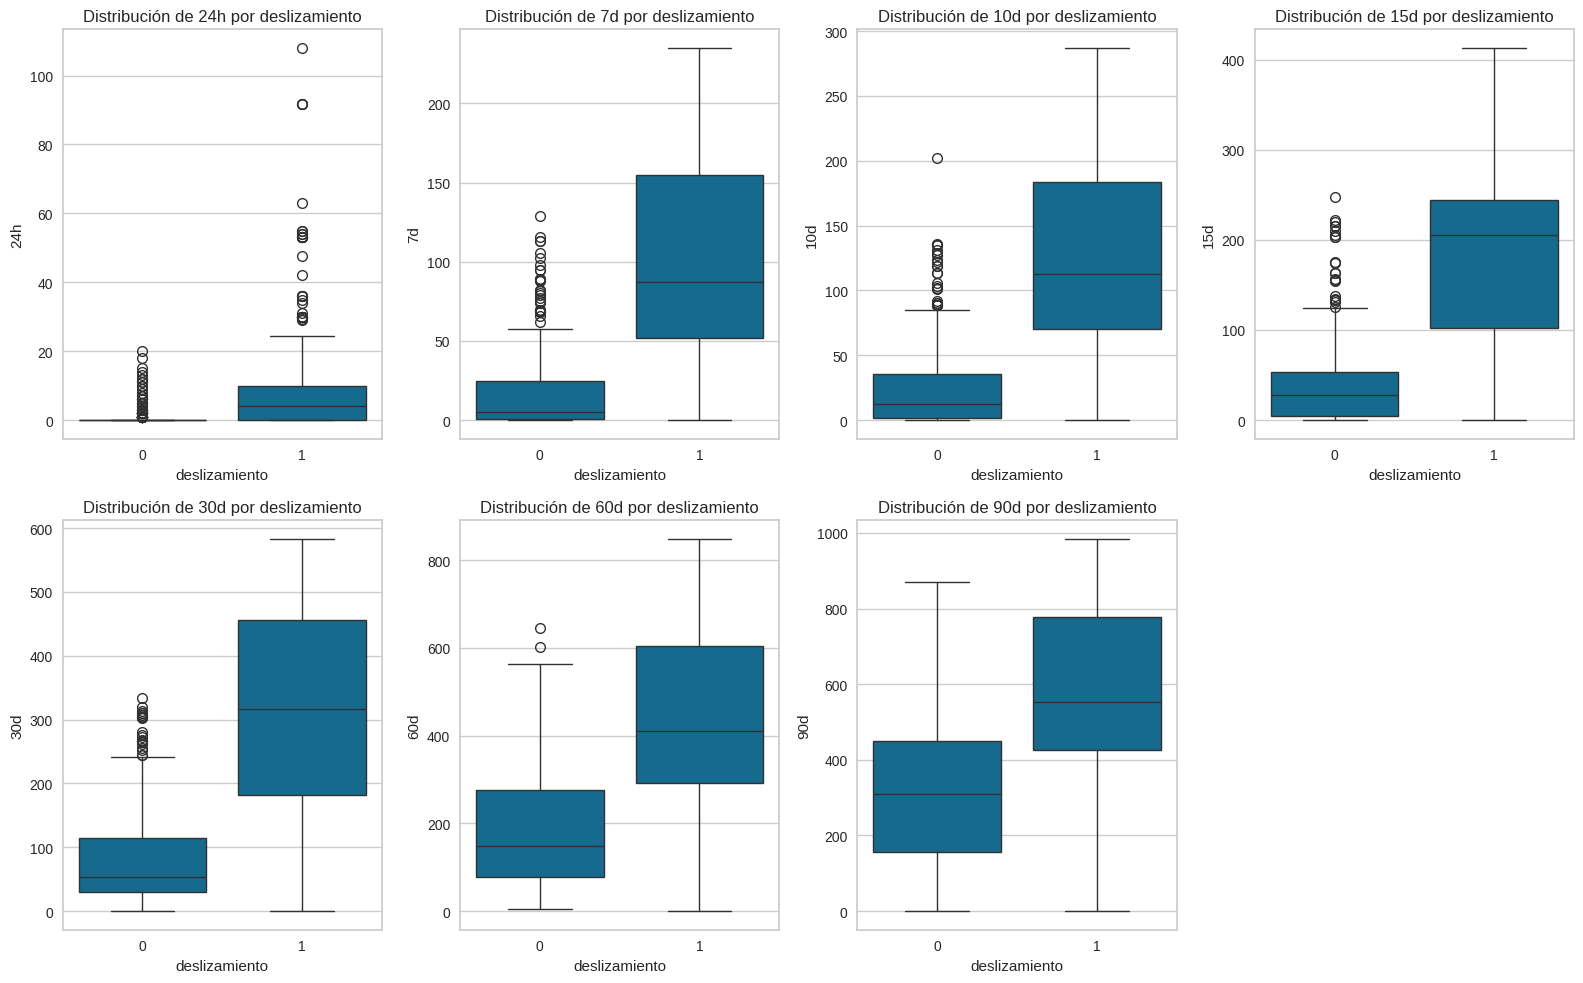

In [30]:
# Configurar el tamaño de la figura y número de subplots
plt.figure(figsize=(16, 10))

# Crear un boxplot para cada columna en la lista
for i, column in enumerate(columnas_a_graficar, 1):
    plt.subplot(2, 4, i)  # Crear una cuadrícula de 2 filas y 4 columnas
    sns.boxplot(x='deslizamientos', y=column, data=df)
    plt.title(f'Distribución de {column} por deslizamiento')
    plt.xlabel('deslizamiento')
    plt.ylabel(column)

# Ajustar el espacio entre los subplots
plt.tight_layout()
plt.show()

- Distribución de la Variable 10d para Cada Valor de deslizamiento: Las variables de precipitaciones poseen una distribución similar entre ellas, esto es, que claramente su distribución es distinta entre los valores de no deslizamiento y sí deslizamiento = 1. Para no deslizamiento, los valores son considerablemente más bajos, con una mediana cercana a los 25. La mayor parte de los datos están concentrados entre 0 y aproximadamente 50, y existen varios valores atípicos alrededor superiores al rango intercuartílico. Para los sí deslizamiento, los valores de precipitación son mucho más altos en promedio. La mediana está se encuentra superior a lo no deslizamientos, y el rango de los datos se extiende mucho más, alcanzando hasta alrededor de 250.

- Variabilidad y Rango: Los datos de precipitaciones para deslizamiento = 1 muestran una variabilidad mucho mayor en comparación con deslizamiento = 0. Esto indica que cuando deslizamiento es igual a 1, las variables de precipitaciones tiende a tener valores más dispersos, y no está tan concentrada alrededor de un valor específico. Para deslizamiento = 0, la mayoría de los datos se encuentran en un rango más estrecho y con menor variabilidad, lo que sugiere que los eventos con deslizamiento = 0 están más limitados a valores bajos de precipitaciones.

- Relación entre precipitaciones y deslizamiento: Esto podría interpretarse como que la condición de deslizamiento = 1 está asociada con situaciones o eventos donde las precipitaciones de lluvia es significativamente mayor, lo cual podría ser relevante en un contexto de riesgo, alertas o indicadores.

## Variables categóricas

Ahora veamos las relaciones de las variables categoricas con el objetivo

In [31]:
resultados = {}
columnas_comparar=['zonificacion','Nomenclatura_del_Suelo','tipo_geologia']
for c in columnas_comparar:
    tabla = crear_tabla_contingencia(df, c, 'deslizamientos')
    resultados[c] = tabla

In [32]:
resultados['zonificacion']

,zonificacion,0,1
5,Riesgo bajo,206,169
1,Amenaza baja,194,15
0,Amenaza alta,0,26
2,Amenaza media,0,27
3,Amenaza muy alta,0,3
4,Riesgo alto,0,206
6,Riesgo medio,0,104


In [33]:
resultados['Nomenclatura_del_Suelo']

,Nomenclatura_del_Suelo,0,1
25,Zonas urbanas continuas,98,401
20,Pasto cultivado arbolado,50,9
19,Pasto cultivado,38,10
26,Zonas urbanas discontinuas,36,25
8,Bosque mixto denso bajo de tierra firme,25,9
21,Pasto cultivado enmalezado,20,3
9,Bosque mixto fragmentado con pastos y cultivos,18,0
15,Otras superficies artificiales con construcción,15,1
24,Vegetación secundaria o transición,14,11
7,Bosque mixto denso alto de tierra firme,13,14


In [34]:
resultados['tipo_geologia']

,tipo_geologia,0,1
8,Formacion Jamundi,96,3
10,Lateritas Formacion Volcanica,86,113
9,Formacion Volcanica,84,345
1,Cono aluvial 2 rio Pance,37,1
0,Cono aluvial 1 rio Pance,28,0
2,Cono aluvial rio Melendez,20,5
7,Formacion Guachinte,20,79
6,Formacion Ferreira,15,0
4,Depositos aluviales,7,1
3,Conos aluviales,3,1


Las variables categóricas con muy pocas frecuencias pueden presentar varios desafíos y consideraciones, por ejemplo: 
  

- Sobre-ajuste: Las categorías que aparecen solo unas pocas veces pueden llevar a modelos que se ajustan demasiado a esos casos específicos, capturando el ruido en lugar de patrones generales. Esto puede disminuir la capacidad de generalización del modelo a datos no vistos.  


- Estabilidad en el entrenamiento: Dado que el modelo tiene pocos ejemplos de estas categorías, puede ser difícil para el modelo aprender patrones representativos. Las categorías con baja frecuencia pueden no tener suficientes datos para permitir que el modelo aprenda características significativas, lo que puede llevar a una mala representación de esas categorías en el modelo. 


Todo esto puede afectar en las métricas de evaluación, como la precisión, el recall, y la F1-score, ya que el rendimiento en estas categorías raras puede no estar bien representado 

## Agrupaciones

Agrupar los datos por la variable objetivo es util para entender las diferencias entre grupos, identificar relaciones con las variables predictoras, evaluar distribuciones y tendencias y facilitar la creación de estrategias de modelado

In [35]:
cols_g=['24h', '15d', '30d', '60d', 'deslizamientos']
df__=df[cols_g]

In [36]:
df__.groupby('deslizamientos').agg(['sum', 'mean', 'count'])

24h                       15d                         30d  \
                   sum      mean count       sum        mean count       sum   
deslizamientos                                                                 
0                353.0  0.882500   400   16423.0   41.057500   400   33964.8   
1               4348.8  7.906909   550  102426.1  186.229273   550  177402.0   

                                       60d                    
                      mean count       sum        mean count  
deslizamientos                                                
0                84.912000   400   75263.5  188.158750   400  
1               322.549091   550  249013.7  452.752182   550

La tabla muestra la acumulación de lluvia (en mm) en diferentes períodos de tiempo: 24 horas, 15 días, 30 días y 60 días, con las agrupaciones basadas en si hay deslizamientos de tierra (1) o no (0)

Claramente, los días con deslizamientos (1) tienen una acumulación de lluvia significativamente mayor que los días sin deslizamientos (0) en todos los intervalos de tiempo.

La diferencia es especialmente notable en los períodos de tiempo más largos (30 y 60 días), donde la acumulación de lluvia promedio en los días con deslizamientos es aproximadamente el doble o más que en los días sin deslizamientos, lo que sugiere que los deslizamientos están asociados a condiciones prolongadas de lluvia intensa.

### Análisis Cluster

En este análisis, se implementará un análisis de clustering como parte del análisis exploratorio para las variables predictoras. El objetivo principal será identificar y entender los perfiles ocultos que existen en los datos de entrenamiento, con el fin de extraer conclusiones valiosas sobre la estructura subyacente de las muestras.

Se utilizarán técnicas de clustering como K-Means para agrupar los datos en función de sus características, sin considerar la variable objetivo. Esto permitirá descubrir patrones, segmentaciones y grupos homogéneos que podrían ofrecer perspectivas adicionales, facilitando la comprensión del problema de clasificación y sugiriendo posibles mejoras en las estrategias de modelado predictivo.

In [37]:
independent_var_erase=[] # Eliminamos la variable de precipitacion acumulada a 10 dias
dependent_var='deslizamientos'
independent_var=[x for x in df.columns if x not in independent_var_erase and x not in dependent_var]
X=df[independent_var]
y=df[dependent_var]
# Seleccionar columnas categoricas
VAR_categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]

# Seleccionar columnas numericas
VAR_numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]

label_encoders = {}
for feature in VAR_categorical_cols:
    le = LabelEncoder()
    X[feature] = le.fit_transform(X[feature])
    label_encoders[feature] = le

In [38]:
X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)

In [39]:
X_scaled.head()

,ELEVACION,PENDIENT,zonificacion,Nomenclatura_del_Suelo,tipo_geologia,24h,7d,10d,15d,30d,60d,90d
0,-0.566235,-0.470035,1.215925,0.635991,0.385252,0.854159,2.144217,1.791373,2.273389,1.997366,1.824370,1.770709
1,0.105551,1.203249,0.118416,0.635991,-0.395942,0.250162,0.327085,0.400193,0.834211,0.671545,0.499336,0.223749
2,-0.527533,0.037522,0.667170,0.635991,-0.395942,0.429474,0.450362,0.497575,0.852142,0.242164,-0.045285,-0.174275
3,2.312436,0.747974,-1.527849,-2.257647,0.385252,-0.467084,-0.593488,-0.545810,-0.680465,-0.717435,-0.646261,-0.752847
4,-0.793653,-0.507262,0.667170,0.635991,-0.395942,0.571035,-0.830436,-0.958990,-0.808812,-0.989469,-0.747701,-0.629747


Escalamos el conjunto de datos para evitar el sesgo debido a escalas diferentes, mejorar la convergencia de K-Means y garantizar la consistencia en la métrica de distancia

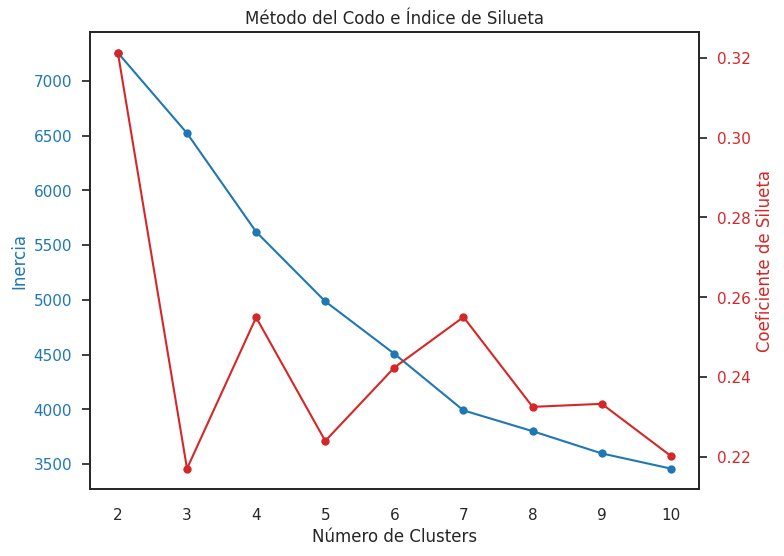

In [51]:
# Inercia para el Método del Codo
inertia = []
# Coeficiente de Silueta
silhouette_scores = []
n_clusters_range = range(2, 11) # de 2 a 10 cluster
clusters_dict = {}

for n in n_clusters_range:
    kmeans = KMeans(n_clusters=n,init='k-means++')
    labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

    # Crear un DataFrame con los datos escalados y la columna "clusters"
    df_with_clusters = X.copy()
    df_with_clusters['clusters'] = labels

    # Guardar en el diccionario con la clave como el número de clusters
    clusters_dict[f'con_{n}_clusters'] = df_with_clusters

# Graficar ambos
fig, ax1 = plt.subplots()

ax1.set_xlabel('Número de Clusters')
ax1.set_ylabel('Inercia', color='tab:blue')
ax1.plot(n_clusters_range, inertia, marker='o', color='tab:blue', label='Inercia')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()  # Crear un segundo eje que comparte el eje x
ax2.set_ylabel('Coeficiente de Silueta', color='tab:red')
ax2.plot(n_clusters_range, silhouette_scores, marker='o', color='tab:red', label='Coef. de Silueta')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.title('Método del Codo e Índice de Silueta')
plt.show()

Utilizaremos el método del codo (`Inercia`) y el `Coeficiente de Silueta` para identificar el número de clusters más optimo. 


Este método evalúa la suma de los errores cuadrados dentro de cada cluster (inertia) para diferentes valores de n_clusters. A medida que aumenta el número de clusters, la inercia disminuye, pero llega un punto en el que la mejora se vuelve marginal. El "codo" en la gráfica es el punto donde el incremento de clusters deja de ofrecer una mejora significativa. 

El coeficiente de silueta mide la separación entre los clusters y qué tan bien están asignadas las muestras dentro de su propio cluster. Los valores del coeficiente de silueta están entre -1 y 1, donde un valor cercano a 1 indica que los puntos están bien agrupados. 


En este mismo orden de las ideas, tenemos que encontrar ese número que nos indique el codo en la serie de la inercia (línea azul) y el coeficiente de silueta más alto en la serie de silueta (línea roja). Vemos que el punto que cumple con esta condición es el 7 

In [41]:
resultado_cluster=clusters_dict['con_7_clusters']
resultado_cluster.head()

,ELEVACION,PENDIENT,zonificacion,Nomenclatura_del_Suelo,tipo_geologia,24h,7d,10d,15d,30d,60d,90d,clusters
0,1030.110840,21.268663,6,25,9,14.0,197.0,210.0,366.0,583.0,746.0,908.0,0
1,1176.433594,56.848099,4,25,7,7.6,83.5,110.0,213.5,343.7,452.1,531.0,4
2,1038.540527,32.060978,5,25,7,9.5,91.2,117.0,215.4,266.2,331.3,434.0,4
3,1657.118408,47.167477,1,5,9,0.0,26.0,42.0,53.0,93.0,198.0,293.0,2
4,980.576721,20.477095,5,25,7,11.0,11.2,12.3,39.4,43.9,175.5,323.0,1


In [42]:
funciones_agregacion = ['mean', 'median', 'count', 'min', 'max']
agg_dict = {col: funciones_agregacion for col in resultado_cluster.columns if 'clusters' not in col}
resultado = resultado_cluster.groupby('clusters').agg(agg_dict)
resultado

ELEVACION                                                PENDIENT  \
                 mean       median count          min          max       mean   
clusters                                                                        
0         1081.343884  1068.523682   153   985.792114  1769.932861  42.480770   
1         1109.291123  1074.063721   221   979.047546  1500.505249  30.774787   
2         1705.272693  1691.590942   102  1398.259766  2098.276855  35.632793   
3         1046.853896  1039.669922    51   984.869446  1181.661743  13.690300   
4         1087.131812  1075.588318   226   975.132202  1599.939087  36.449945   
5         1014.184948   979.652466    48   972.612610  1300.178345  11.900871   
6         1097.128918  1079.523193   149   978.607788  1488.616699  21.862463   

                                                 ...         60d          \
             median count       min         max  ...        mean  median   
clusters                                         ...                       
0         41.846062   153  3.538649   89.237999  ...  672.419608  735.00   
1         26.067751   221  2.509326   84.404579  ...  180.012217  185.60   
2         28.213477   102  1.930219  101.956207  ...  246.046078  266.80   
3         11.322103    51  3.015621   40.761745  ...  212.407843  160.00   
4         33.249146   226  1.330287   94.294182  ...  468.573009  444.55   
5          9.840033    48  1.231035   41.481342  ...  168.733333  128.75   
6         17.751278   149  0.984309   92.066528  ...  212.671812  208.80   

                                     90d                              
         count    min    max        mean  median count    min    max  
clusters                                                              
0          153  446.0  753.0  827.745098  878.00   153  666.0  918.0  
1          221    0.0  484.8  293.068326  309.20   221    0.0  706.8  
2          102   23.0  521.4  378.537255  364.00   102  103.0  815.6  
3           51   44.2  538.0  344.890196  345.80    51   93.4  722.6  
4          226  203.4  848.0  602.109735  536.00   226  284.0  984.0  
5           48   17.4  533.0  297.070833  308.35    48   44.0  722.6  
6          149   24.7  577.5  367.104027  353.90   149   62.7  742.2  

[7 rows x 60 columns]

Vemos el perfil de la variable de lluvia acumulada en las ultimas 24h

In [43]:
resultado['24h']

,mean,median,count,min,max
clusters,,,,,
0,6.282353,10.0,153,0.0,29.0
1,1.927149,0.0,221,0.0,20.0
2,3.359804,0.0,102,0.0,47.6
3,0.392157,0.0,51,0.0,6.0
4,12.016372,6.3,226,0.0,108.0
5,0.841667,0.0,48,0.0,19.8
6,1.314765,0.0,149,0.0,30.0


Observamos que para el cluster 0, 2, 4 y 5 podría representar aquel grupo con niveles de lluvias acumuladas más bajos, mientras que los cluster numero 1, 3 y 6 con los mayores niveles al observar sus medidas de agrupación.

Ahora observemos la variable de `PENDIENT`

In [44]:
resultado['PENDIENT']

,mean,median,count,min,max
clusters,,,,,
0,42.480770,41.846062,153,3.538649,89.237999
1,30.774787,26.067751,221,2.509326,84.404579
2,35.632793,28.213477,102,1.930219,101.956207
3,13.690300,11.322103,51,3.015621,40.761745
4,36.449945,33.249146,226,1.330287,94.294182
5,11.900871,9.840033,48,1.231035,41.481342
6,21.862463,17.751278,149,0.984309,92.066528


el cluster 0,4 y 6 son los que representan agrupan esos registros que representan terrenos con menos porcentajes de pendientes. 

Vemos que el punto óptimo en nuestra implementación de `K-Means` son 7 agrupaciones, esto nos puede dar indicios de que nuestro conjunto de datos se segmenta en las 7 clases de la variable `Zonificacion`, la cual es un nivel de riesgo, es decir, un nombre de la clasificación de amenaza o riesgo del punto de movimiento en masa asignado por geólogos de la alcaldía de Cali basado en el historial de casos de deslizamientos de tierra en la ciudad

Aunque sean bastantes cluster, se evidencia que la mayoría de cluster apuntan a 2 agrupamientos, es decir que nos tratan de decir que hay 2 clases de población dentro de nuestro conjunto de datos 

## Árbol de Decisión

Entrenar un solo árbol de decisión en un EDA puede ser útil para identificar rápidamente qué variables tienen mayor relevancia en la predicción del objetivo.

Los árboles de decisión dividen los datos en función de las características más informativas, esto te permite identificar qué variables son más útiles para predecir la variable dependiente. Tambien es nos ayuda en la interpretabilidad, ya que el árbol muestra claramente cómo se hace la toma de decisiones basadas en las características y qué variables se consideran importantes a cada paso y a la identificación de relaciones no lineales, porque pueden manejar relaciones no lineales entre variables, lo que te permite captar patrones que a veces no son evidentes con técnicas lineales.

In [45]:
independent_var_erase=['10d'] # Eliminamos la variable de precipitacion acumulada a 10 dias
dependent_var='deslizamientos'
independent_var=[x for x in df.columns if x not in independent_var_erase and x not in dependent_var]
X=df[independent_var]
y=df[dependent_var]
VAR_categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]
VAR_numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
VAR_cols = VAR_categorical_cols + VAR_numerical_cols
label_encoders = {}

for feature in VAR_categorical_cols:
    le = LabelEncoder()
    X[feature] = le.fit_transform(X[feature])
    label_encoders[feature] = le

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=23)

In [46]:
tree = DecisionTreeClassifier(max_depth=4)
tree.fit(X_train, y_train)
# Hacer predicciones en el conjunto de prueba
y_pred = tree.predict(X_test)

# Medir el rendimiento (en clasificación, por ejemplo)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8842105263157894


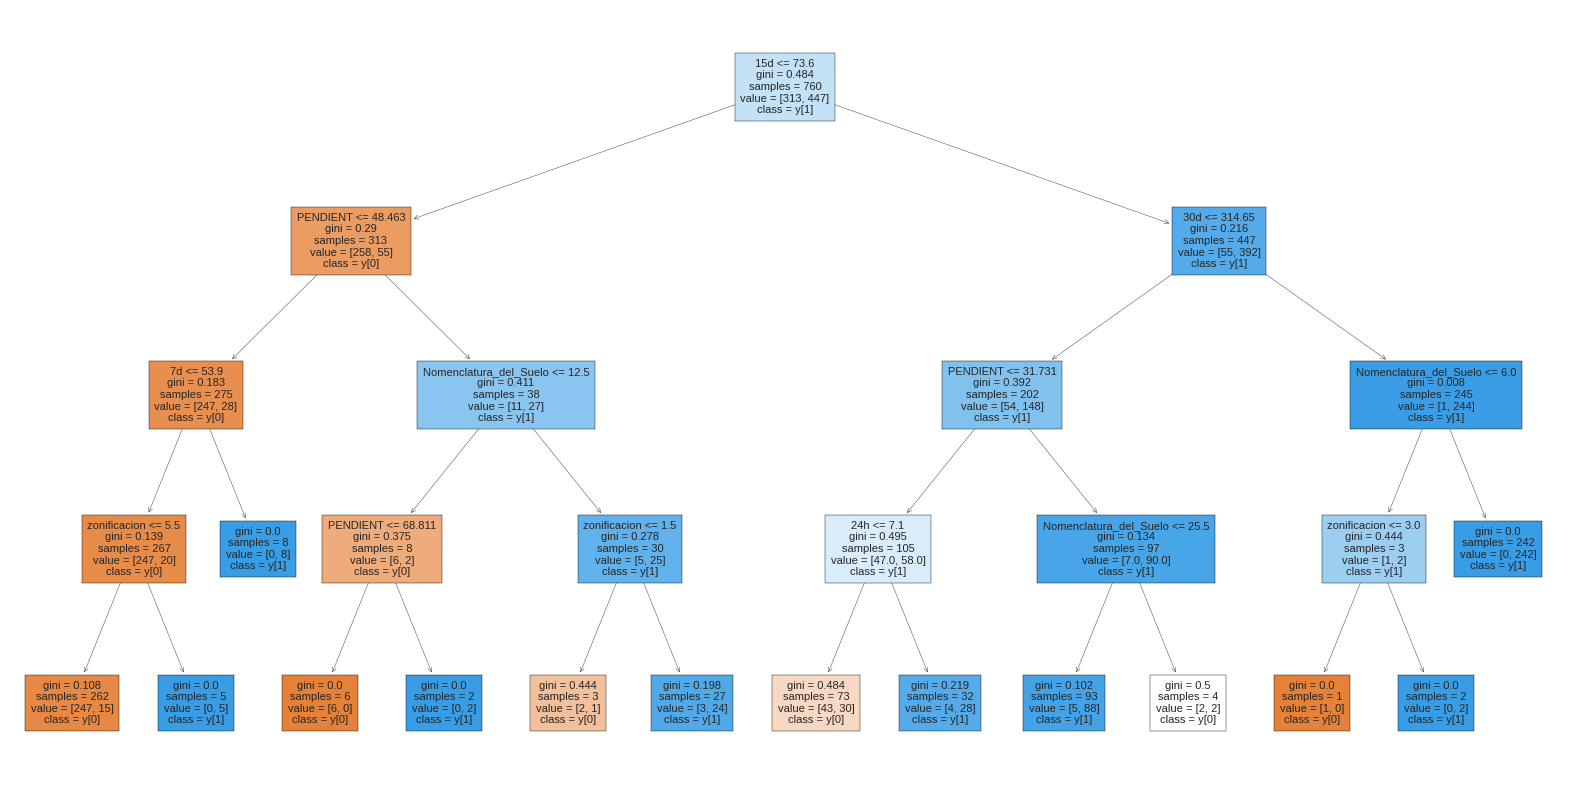

In [47]:
plt.figure(figsize=(20,10))  # Ajustar el tamaño de la figura
plot_tree(tree, 
          filled=True, 
          feature_names=X.columns, 
          class_names=True, 
          rounded=False, 
          fontsize=8)  # Ajustar el tamaño de la letra
plt.show()

El nodo raíz indica que la primera condición a evaluar es la `15d` (Precipitación de lluvia acumulada en 15 días en milímetros) del terreno. Si la varaible es menor o igual a 73.6, se avanza por la rama izquierda; de lo contrario, se avanza por la derecha.

Los nodos finales (hojas) muestran la clase predicha (0 o 1) y el número de muestras en cada hoja. También se indica el valor de las muestras clasificadas, con la mayoría en una clase reflejando el resultado esperado.
Por ejemplo, un nodo puede indicar que, si `PENDIENT` es menor o igual a 48.463 y `7d` es menor o igual a 53.9, se clasifica como `deslizamiento` (y[1]).

El `índice de Gini` se muestra en cada nodo, que mide la pureza de los nodos. Un valor de 0 indica pureza completa (todas las muestras de una clase) y valores cercanos a 1 indican mezcla de clases. Los nodos con menor índice de Gini se consideran mejores para la clasificación.

Las variables más significativas como `15d`, `PENDIENT`, y `30d`, son cruciales para determinar la probabilidad de deslizamientos.

## Correlaciones entre variables independientes

El objetivo es que exista la menor correlación lineal y no lineal entre las variables independientes, ya que deseamos que cada variable aporte su valor independiente al modelo, y evitar redundancias

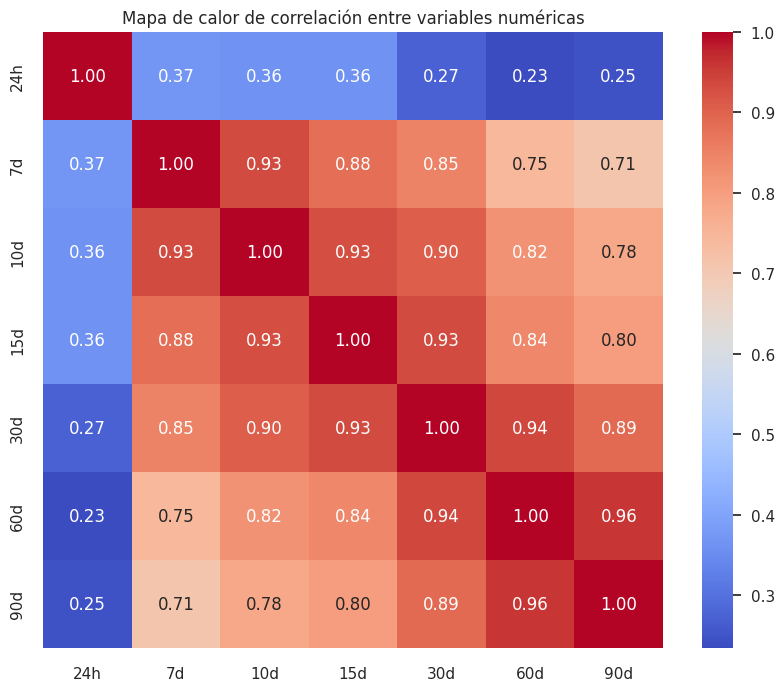

In [48]:
# Correlaciones entre variables independientes
correlation_matrix = df[columnas_a_graficar].corr(method='pearson')

# Configurar el estilo del mapa de calor

sns.set(style="white")

# Crear el mapa de calor de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Añadir título
plt.title('Mapa de calor de correlación entre variables numéricas')

# Mostrar el mapa de calor
plt.show()

Observamos que existe una alta correlación lineal entre las variables númericas de precipitación, dándonos a entender que no son del todo independientes y que a medida que suben los dias (10 dias, 15 dias, 30 dias y así sucesivamente) aumenta su dependencia.


Esto genera multicolinealidad, lo que puede hacer que los coeficientes en modelos lineales (como la regresión logística, que se modelará en este analisis) se vuelvan inestables y difíciles de interpretar, esto ocurre porque el modelo no puede distinguir fácilmente el efecto individual de cada variable correlacionada. 


Tambien se podria explorar como se ve la matriz de correlaciones, eliminando algunas variables para hacer mas grande la brecha que separa los dias acumulados, es decir en ves de usar una variable como `7d` y `10d`, usar variables que representen brechas de acumulacion de lluvia mas grande para tratar de disminuir la multicolinealidad

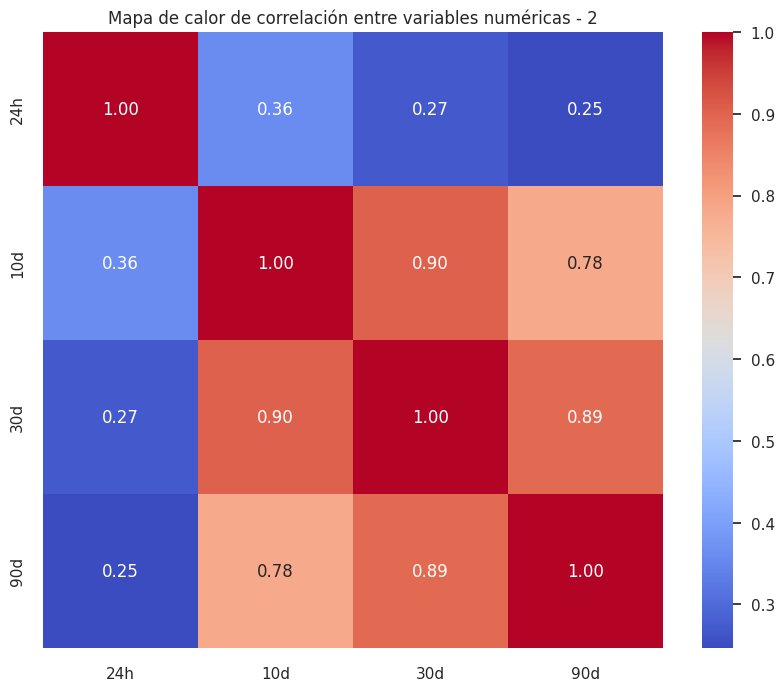

In [49]:
columnas_a_graficar2 = ['24h','10d','30d','90d'] 
# Correlaciones entre variables independientes
correlation_matrix = df[columnas_a_graficar2].corr(method='pearson')

# Configurar el estilo del mapa de calor

sns.set(style="white")

# Crear el mapa de calor de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Añadir título
plt.title('Mapa de calor de correlación entre variables numéricas - 2')

# Mostrar el mapa de calor
plt.show()

Al eliminar ciertas variables, el mapa de calor se torna menos rojo, es decir hay menos variables que nos aportan multicolinealidad. Este conjunto de variables se pueden evaluar para la selecicon de features a tomar en cuenta para cada modelo. 

Las variables altamente correlacionadas aportan información redundante. Esto puede hacer que el modelo sea más complejo de lo necesario, sin mejorar el rendimiento predictivo, lo cual puede llevar a un modelo sobre ajustado que no generaliza bien a datos nuevos. En algunos casos, los algoritmos de clasificación que se usarán en este análisis, como los árboles de decisión o los modelos basados en conjuntos (e.g., Random Forest, XGBoost), no se ven tan afectados por la multicolinealidad, pero la presencia de variables altamente correlacionadas puede todavía llevar a un modelo más complejo de lo necesario.

## Decisiones

Del EDA podemos concluir que sería bueno eliminar ciertas variables numéricas debido a la alta redundancia entre las mismas, esta decisión dependerá del modelo a utilizar, ya que esto afecta de maneras diferentes cada modelo. En cuanto a las variables categóricas se decidirá trabajar con todas, se usará un codificador de etiquetas y no un one-hot encoder debido a la cantidad de clases que puede tomar una categoría.  

  

La data de entrenamiento puede variar dependiendo del modelo a usar y los rendimientos de este.

### ¿Por qué utilizar Modelos de ML?

Para determinar si es necesario un enfoque de Machine Learning y aplicar analítica predictiva o si solo es necesario un método de clasificación más sencillo, primero debemos comprender el problema en este caso, se quiere estimar la probabilidad de que un registro pertenezca a la clase "1" o "0", lo cual se puede abordar como un problema de clasificación binaria. Sin embargo, lo que debes analizar es la complejidad del problema para decidir si un enfoque más simple es suficiente. 

Para esto, se procede en esta sección a **evaluar la complejidad de las relaciones entre las variables** donde se exploran las relaciones entre las variables mediante visualizaciones como gráficos de dispersión, histogramas o matrices de correlación. Podemos también indagar si las variables predictoras están fuertemente correlacionadas con la variable objetivo, es posible que un modelo simple de estadística (como una regresión logística) sea suficiente. 

También, para evaluar el por qué usar modelos de ML, en esta seccion de prueban modelos simples y técnicas de agrupamiento para medir que tanto valor aportan para nuestro objetivo de investigación, como una clusterizacion y la aplicación simple de un árbol de decisión. 

De la misma manera, se puede indagar en la implementación de varios modelos, así como hacemos en las otras secciones de esta página. En cada una de estas implementaciones, se evalúa el rendimiento de cada modelo para ver si un método inclinado por el aprendizaje de maquina puede resolver nuestro problema o no. 

Un punto muy a favor de porque usar modelos de ML en este estudio, es que capturan patrones complejos. Los modelos de ML pueden identificar relaciones no lineales y complejas entre la variable binaria deslizamiento y otras variables numéricas (como las de precipitaciones). Esto es difícil de lograr con técnicas básicas, que a menudo asumen una relación lineal. También nos ofrece grandes ventajas como Capacidad para Manejar Múltiples Variables, Flexibilidad y Escalabilidad, Reducción del Sesgo Humano. 

En resumen, los modelos de ML ofrecen una mayor precisión, adaptabilidad y eficiencia, lo que los hace ideales para clasificar deslizamiento en escenarios donde los patrones de los datos son complejos y cambiantes. 